In [1]:
import os,sys,subprocess,glob,cftime,importlib,pickle,itertools
from datetime import datetime
import xarray as xr
import numpy as np
import pandas as pd
sys.path.append('../')

def import_from(module, name):
    module = __import__(module, fromlist=[name])
    return getattr(module, name)

from ensembles.ensemble_GKLT import ensemble_GKLT,get_weight_for_selection

%load_ext autoreload
%autoreload 2

In [18]:
class cmd:
    project_path = '../REA_heat_wEU_JJA'
    experiment_identifiers = ['c12_wet']
command_line_arguments = cmd

In [2]:
class cmd:
    project_path = '../REA_low_u500_atl_jja'
    experiment_identifiers = ['c2']
command_line_arguments = cmd

In [4]:
sys.path.append(command_line_arguments.project_path)
from experiment_configuration.experiment import experiment

for experiment_identifier in command_line_arguments.experiment_identifiers:
    print(experiment_identifier)
    exp = experiment(importlib.import_module(f"experiment_configuration.{experiment_identifier}").config)

    exp_new_name = ''.join(exp.experiment_identifier.split('_')[0][1:])

    naming_d = {
        "project": 'REA_output',
        "product": exp.product_name,
        "institute": 'NCAR',
        "model": 'CESM2',
        "experiment" : f"{exp.initial_conditions_name}-x{exp_new_name}",
        "realm": "meta",
    }
    out_dir = '/'.join([exp.dir_work] + [v for k,v in naming_d.items()])
    os.makedirs(out_dir, exist_ok=True)

    obs = xr.open_mfdataset(f"{exp.dir_work}/REA_output/{exp.product_name}/NCAR/CESM2/{exp.initial_conditions_name}-x{exp_new_name}/meta/obs/*/*", concat_dim='sim', combine='nested')['obs'].load()

    ens = ensemble_GKLT(exp)
    ens.evaluate_weights_and_probabilities(obs)
    print(ens._prob)
    print(ens._weight_from_algo)
    xr.Dataset({'probability':ens._prob}).to_netcdf(f"{out_dir}/probability_season_{naming_d['experiment']}.nc")
    xr.Dataset({'weight':ens._weight_from_algo}).to_netcdf(f"{out_dir}/weight_season_{naming_d['experiment']}.nc")

c2
<xarray.DataArray 'obs' (sim: 126)> Size: 1kB
array([2.99119229e+00, 7.70418328e-01, 3.62238646e-01, 1.52790155e-03,
       2.66641457e-03, 2.15047743e-02, 5.88782212e-02, 2.36810972e-01,
       3.25320105e-01, 6.56317738e-01, 2.64009472e-01, 1.54227622e-02,
       7.88443512e-02, 3.70227494e-02, 9.02875637e-04, 7.73139852e-05,
       3.43878637e-03, 1.14002019e-02, 4.76958726e-02, 8.98056676e-03,
       2.56864952e-02, 4.46633546e-03, 1.06897932e-02, 4.57608417e-02,
       3.03907980e-03, 8.29953453e-03, 1.50908537e-01, 9.08279952e-01,
       2.55827536e-01, 3.51128625e-01, 3.74420067e-01, 1.05206116e+00,
       2.20020027e+00, 1.35819676e+00, 4.45287838e-01, 7.61364040e-02,
       9.07232012e-02, 1.45646629e-02, 5.05737550e-02, 1.92832925e-03,
       1.40411107e-01, 9.47123532e-02, 1.03450572e-01, 8.27982861e-02,
       6.53309006e-02, 1.92754734e-02, 6.68461829e-03, 2.45593780e-02,
       2.74273542e-02, 9.88951962e-02, 4.02281485e-03, 9.98989885e-03,
       2.92487108e-02, 1.668

In [7]:
ens._prob.max()

<xarray.DataArray 'obs' ()> Size: 8B
array(9.74268783)

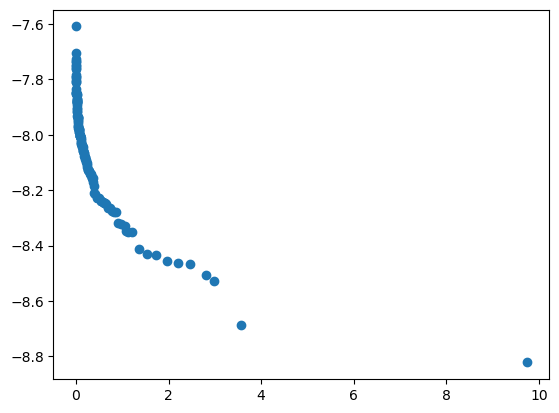

In [11]:
import matplotlib.pyplot as plt
plt.scatter(ens._prob.values, ens._obs.mean('time'))

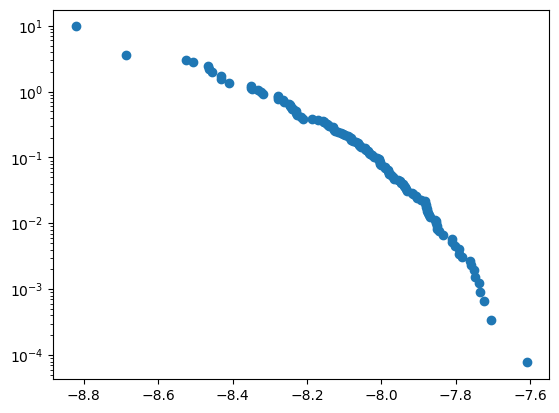

In [13]:
fig,ax=plt.subplots()
ax.scatter(ens._obs.mean('time'), ens._prob.values, )
ax.set_yscale('log')